<a href="https://colab.research.google.com/github/lharikumar/OpenAI_FunctionCalling/blob/main/ExtractStructData_FC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pre-requisites:**

1.   Get the OpenAI API key at https://platform.openai.com/account/api-keys
2.   We need a text to extract structured data from. I have taken the first two paragraphs from https://www.npr.org/2022/09/23/1124900604/roger-federer-loses-final-match-laver-cup


**Note:**

*   Store the OpenAI API key as an environment variable. Never use them directly in the code

In [1]:
!pip install -qU python-dotenv openai

In [2]:
import os
import dotenv
import openai
import json

In [3]:
dotenv.load_dotenv('/content/env_files/.env')
openai.api_key = os.getenv('OPENAI_API_KEY')

In [4]:
def process_extracted_data(people):
  json_formatted_str = json.dumps(people, indent=2)
  return(json_formatted_str)

In [5]:
tmplist =  [{"name":"n1","birthday":"January 1, 1900", "profession" : "p1", "home_country": "h1"},{"name":"n2","birthday":"December 1, 1900", "profession" : "p2", "home_country": "h2"}]

print(process_extracted_data(tmplist))

[
  {
    "name": "n1",
    "birthday": "January 1, 1900",
    "profession": "p1",
    "home_country": "h1"
  },
  {
    "name": "n2",
    "birthday": "December 1, 1900",
    "profession": "p2",
    "home_country": "h2"
  }
]


In [6]:
text_to_analyze = "This day, this match, had to come, of course, for Roger Federer, and for tennis, just as it inevitably must for every athlete in every sport. Federer bid adieu Friday night with one last contest before he heads into retirement at age 41 after a superlative career that spanned nearly a quarter-century and included 20 Grand Slam titles and a statesman's role. He wrapped up his days as a professional player with a loss in doubles alongside his longtime rival Rafael Nadal for Team Europe in the Laver Cup against Frances Tiafoe and Jack Sock of Team World."

# OpenAI Function Calling

## Step 1 - Call the model with functions and the user’s input

In [7]:
messages = [{"role": "user", "content": text_to_analyze}]

In [8]:
functions = [
        {
            "name": "extract_structured_data",
            "description": "Extraction of all individuals mentioned in the article, including their names, birthdays, profession and home country.",
            "parameters": {
                "type": "object",
                "properties": {
                    "people": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "name" : {
                                    "type": "string",
                                    "description": "Name of the individual"
                                },
                                "birthday" : {
                                    "type": "string",
                                    "description": "Birthday of the individual"
                                },
                                "profession" : {
                                    "type": "string",
                                    "description": "Profession of the individual"
                                },
                                "home_country" : {
                                    "type": "string",
                                    "description": "Home country of the individual"
                                }
                            }
                        }
                    },
                },
                "required": ["people"],
            },
        }
    ]

In [9]:
available_functions = {
            "extract_structured_data": process_extracted_data,
        }

In [10]:
response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=messages,
        functions=functions,
        function_call="auto"
    )

## Step 2 - Use the model response to call your API

In [11]:
response_msg = response.choices[0].message
if response_msg.get("function_call"):
    function_name = response_msg["function_call"]["name"]
    function_to_call = available_functions[function_name]
    function_args = json.loads(response_msg["function_call"]["arguments"])
    function_response = function_to_call(
            people=function_args.get("people")
    )

In [12]:
print(response_msg)

{
  "role": "assistant",
  "content": null,
  "function_call": {
    "name": "extract_structured_data",
    "arguments": "{\n  \"people\": [\n    {\n      \"name\": \"Roger Federer\",\n      \"birthday\": \"August 8, 1981\",\n      \"profession\": \"Tennis player\",\n      \"home_country\": \"Switzerland\"\n    },\n    {\n      \"name\": \"Rafael Nadal\",\n      \"birthday\": \"June 3, 1986\",\n      \"profession\": \"Tennis player\",\n      \"home_country\": \"Spain\"\n    },\n    {\n      \"name\": \"Frances Tiafoe\",\n      \"birthday\": \"January 20, 1998\",\n      \"profession\": \"Tennis player\",\n      \"home_country\": \"United States\"\n    },\n    {\n      \"name\": \"Jack Sock\",\n      \"birthday\": \"September 24, 1992\",\n      \"profession\": \"Tennis player\",\n      \"home_country\": \"United States\"\n    }\n  ]\n}"
  }
}


In [13]:
print(function_response)

[
  {
    "name": "Roger Federer",
    "birthday": "August 8, 1981",
    "profession": "Tennis player",
    "home_country": "Switzerland"
  },
  {
    "name": "Rafael Nadal",
    "birthday": "June 3, 1986",
    "profession": "Tennis player",
    "home_country": "Spain"
  },
  {
    "name": "Frances Tiafoe",
    "birthday": "January 20, 1998",
    "profession": "Tennis player",
    "home_country": "United States"
  },
  {
    "name": "Jack Sock",
    "birthday": "September 24, 1992",
    "profession": "Tennis player",
    "home_country": "United States"
  }
]


## Step 3 - Send the response back to the model to summarize

In [14]:
messages.append(response_msg)  # extend conversation with assistant's reply
messages.append(
            {
                "role": "function",
                "name": function_name,
                "content": function_response,
            }
        )  # extend conversation with function response
response_to_user = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0613",
            messages=messages,
        )  # get a new response from GPT where it can see the function response

In [16]:
response_to_user

<OpenAIObject chat.completion id=chatcmpl-7Yku9c2ckDValJzv6askl1kjblxul at 0x7f00a4521e40> JSON: {
  "id": "chatcmpl-7Yku9c2ckDValJzv6askl1kjblxul",
  "object": "chat.completion",
  "created": 1688517809,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Roger Federer, born on August 8, 1981, is a Swiss tennis player. He had a remarkable career spanning almost a quarter-century and achieved 20 Grand Slam titles. Federer, at the age of 41, played his last match on Friday night before retiring from professional tennis. In this farewell match, he teamed up with his long-time rival Rafael Nadal to play doubles for Team Europe in the Laver Cup against Team World's Frances Tiafoe and Jack Sock. Rafael Nadal, born on June 3, 1986, is a Spanish tennis player. Frances Tiafoe, born on January 20, 1998, represents the United States, and Jack Sock, born on September 24, 1992, is also an American tennis player

## Ensuring that the responses are correct!!!

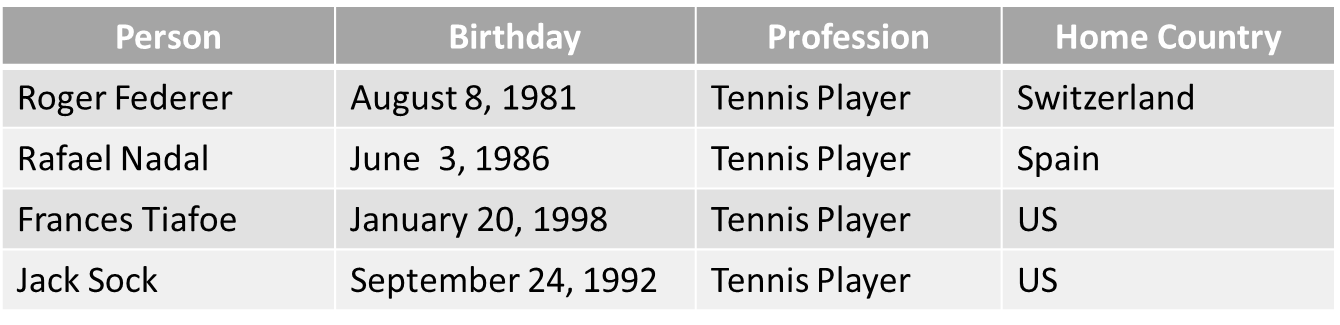